In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
cwd = os.getcwd()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2498560/45929032 bytes (5.4%)6651904/45929032 bytes (14.5%)10698752/45929032 bytes (23.3%)14802944/45929032 bytes (32.2%)18907136/45929032 bytes (41.2%)22962176/45929032 bytes (50.0%)27049984/45929032 bytes (58.9%)31088640/45929032 bytes (67.7%)35004416/45929032 bytes (76.2%)38805504/45929032 bytes (84.5%)42860544/45929032 bytes (93.3%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [0]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [4]:
test_images = [plt.imread(path) for path in glob.glob('/content/gdrive/My Drive/app/parking_spots_detector/test_images/*.jpg')]

show_images(test_images)

Output hidden; open in https://colab.research.google.com to view.

### **Color Selection and Edge Detection**

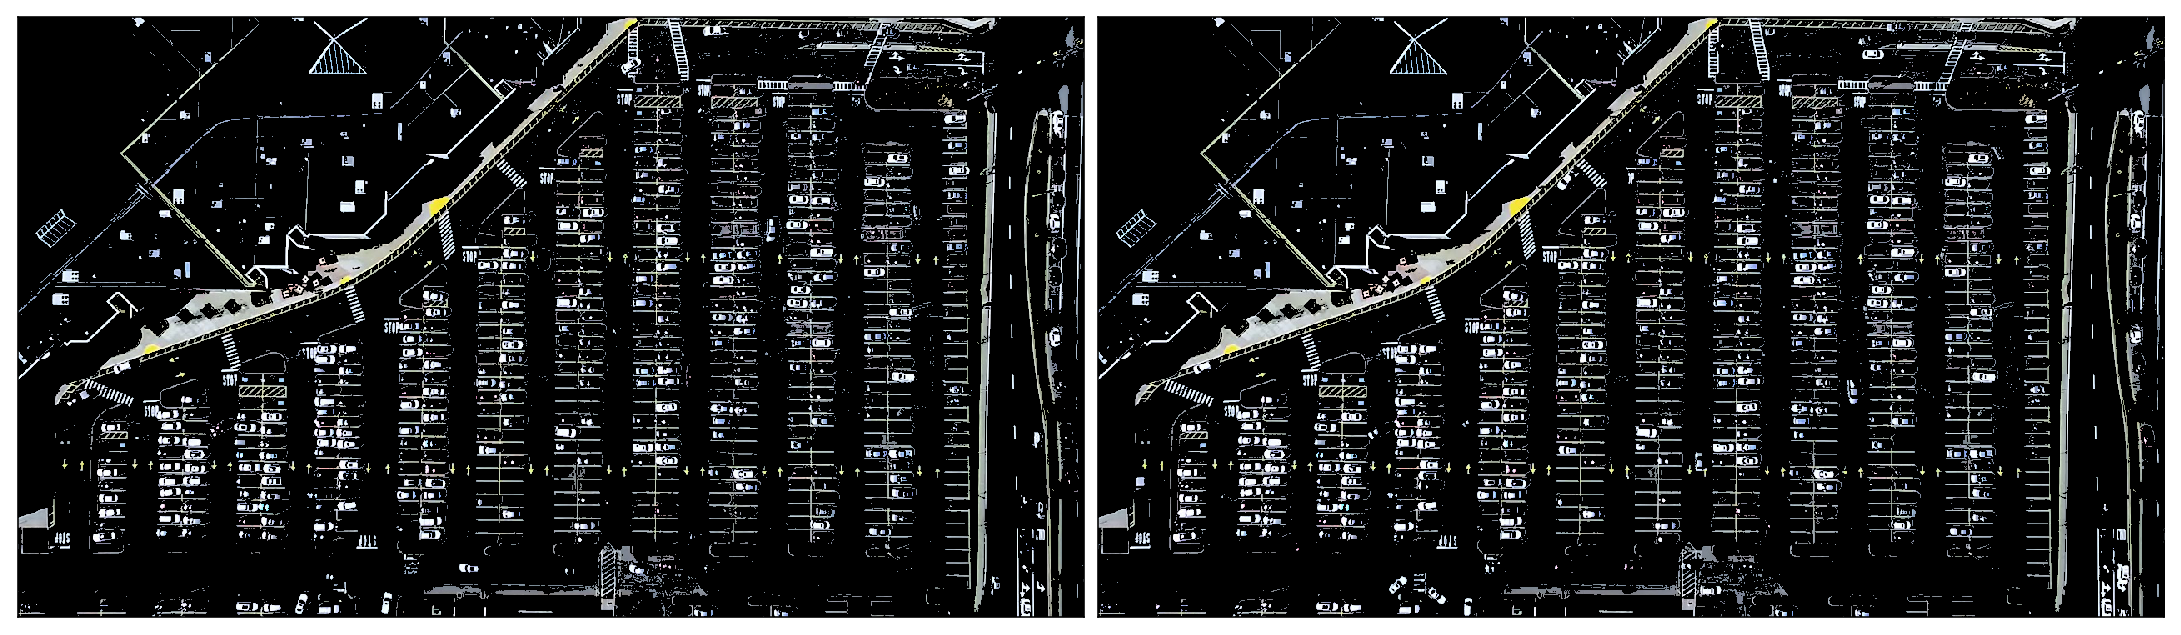

In [5]:
# image is expected be in RGB color space# image 
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([120, 120, 120])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

white_yellow_images = list(map(select_rgb_white_yellow, test_images))
show_images(white_yellow_images)

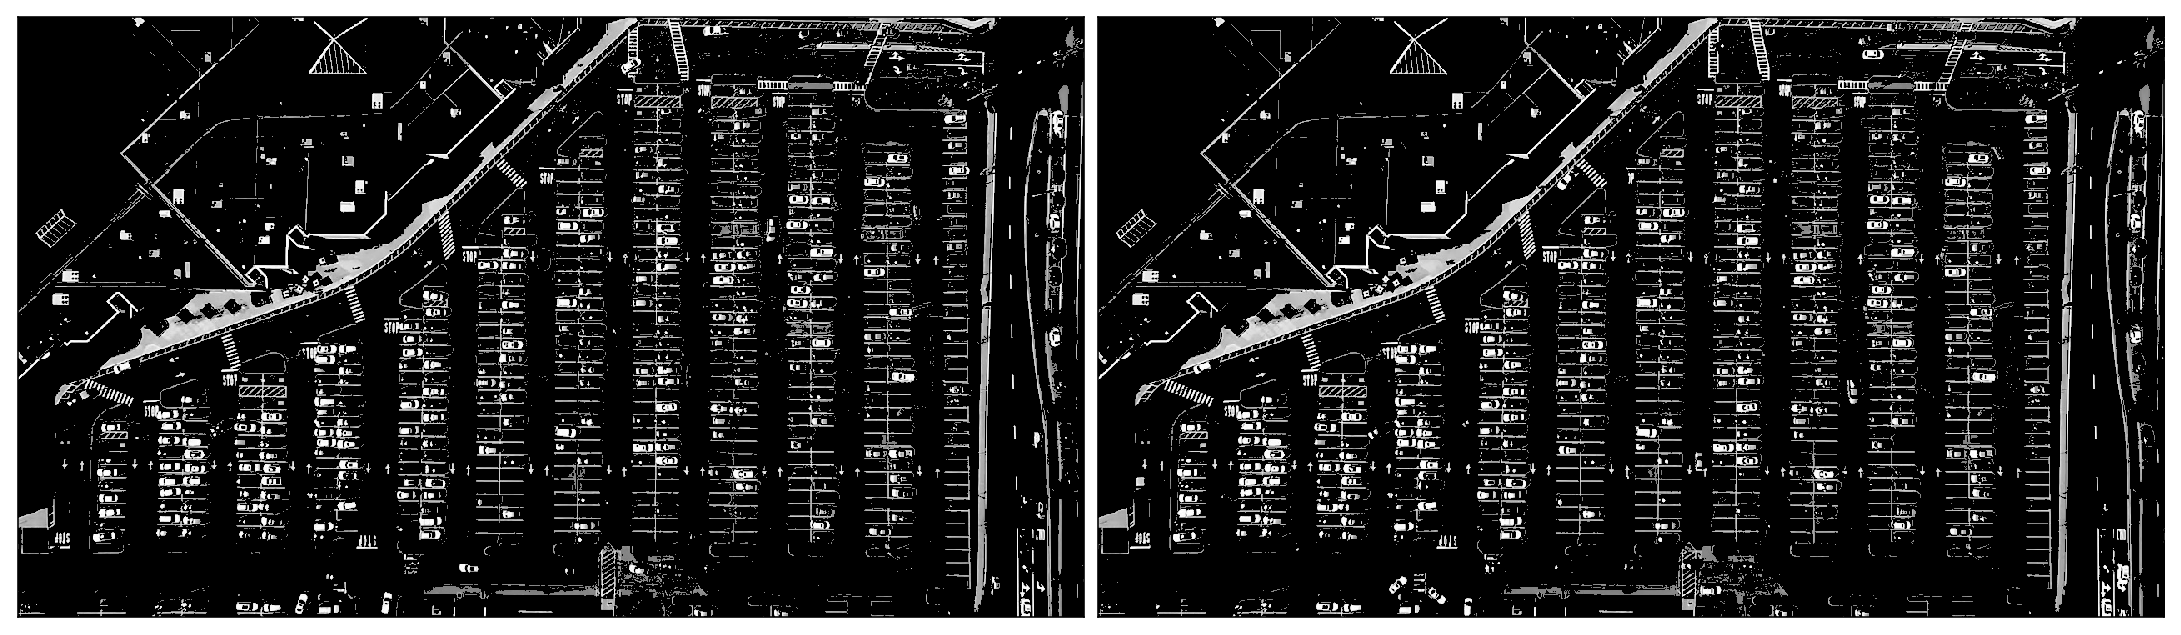

In [6]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

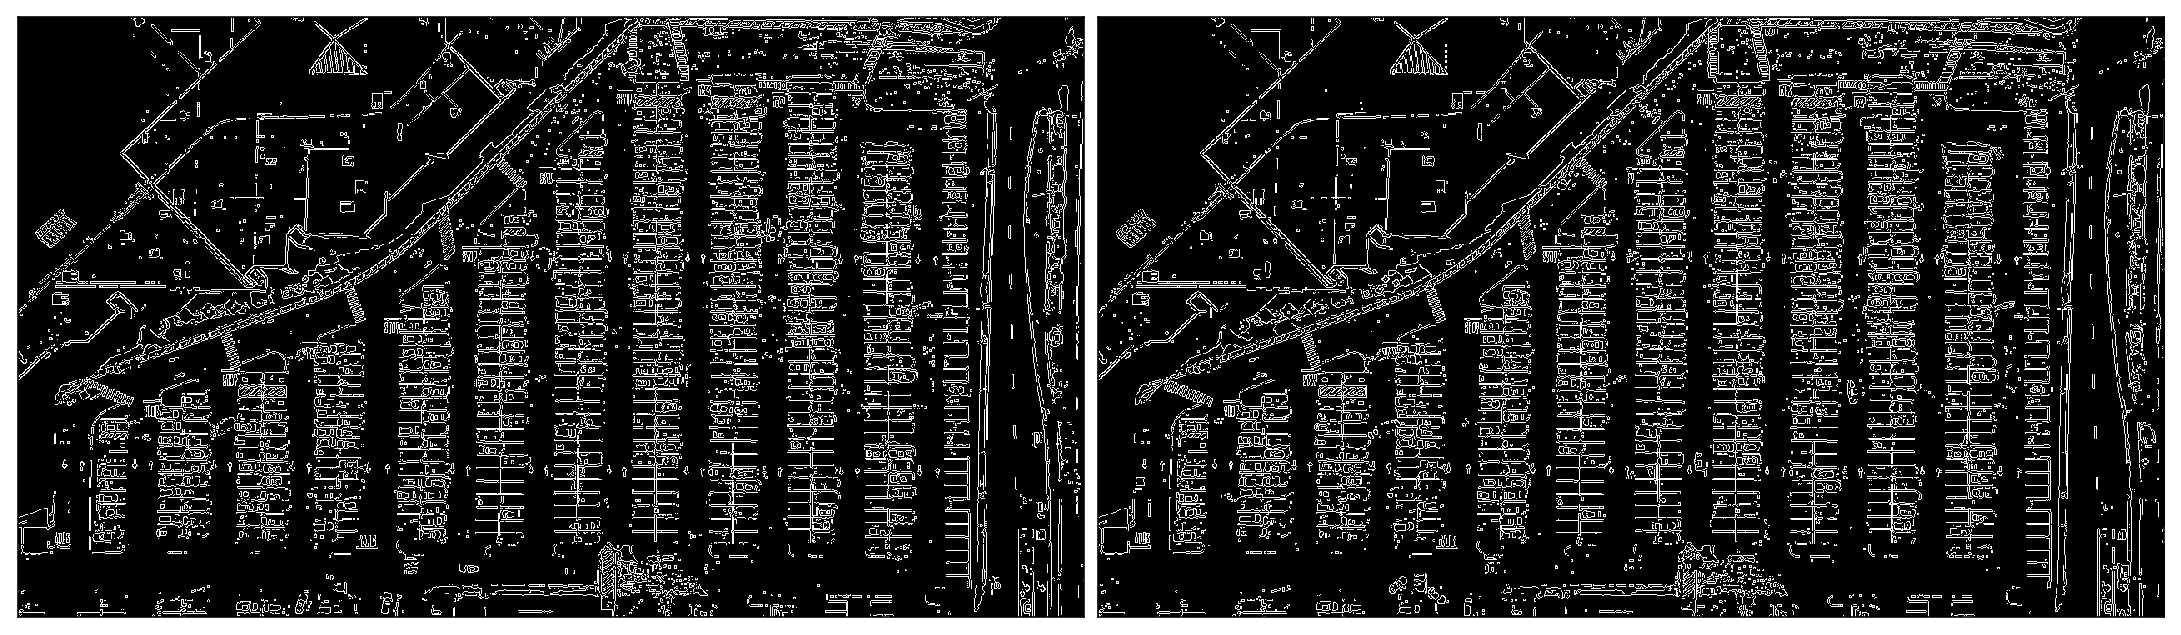

In [7]:
def detect_edges(image, low_threshold=50, high_threshold=200):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), gray_images))

show_images(edge_images)

### **Identify area of interest**

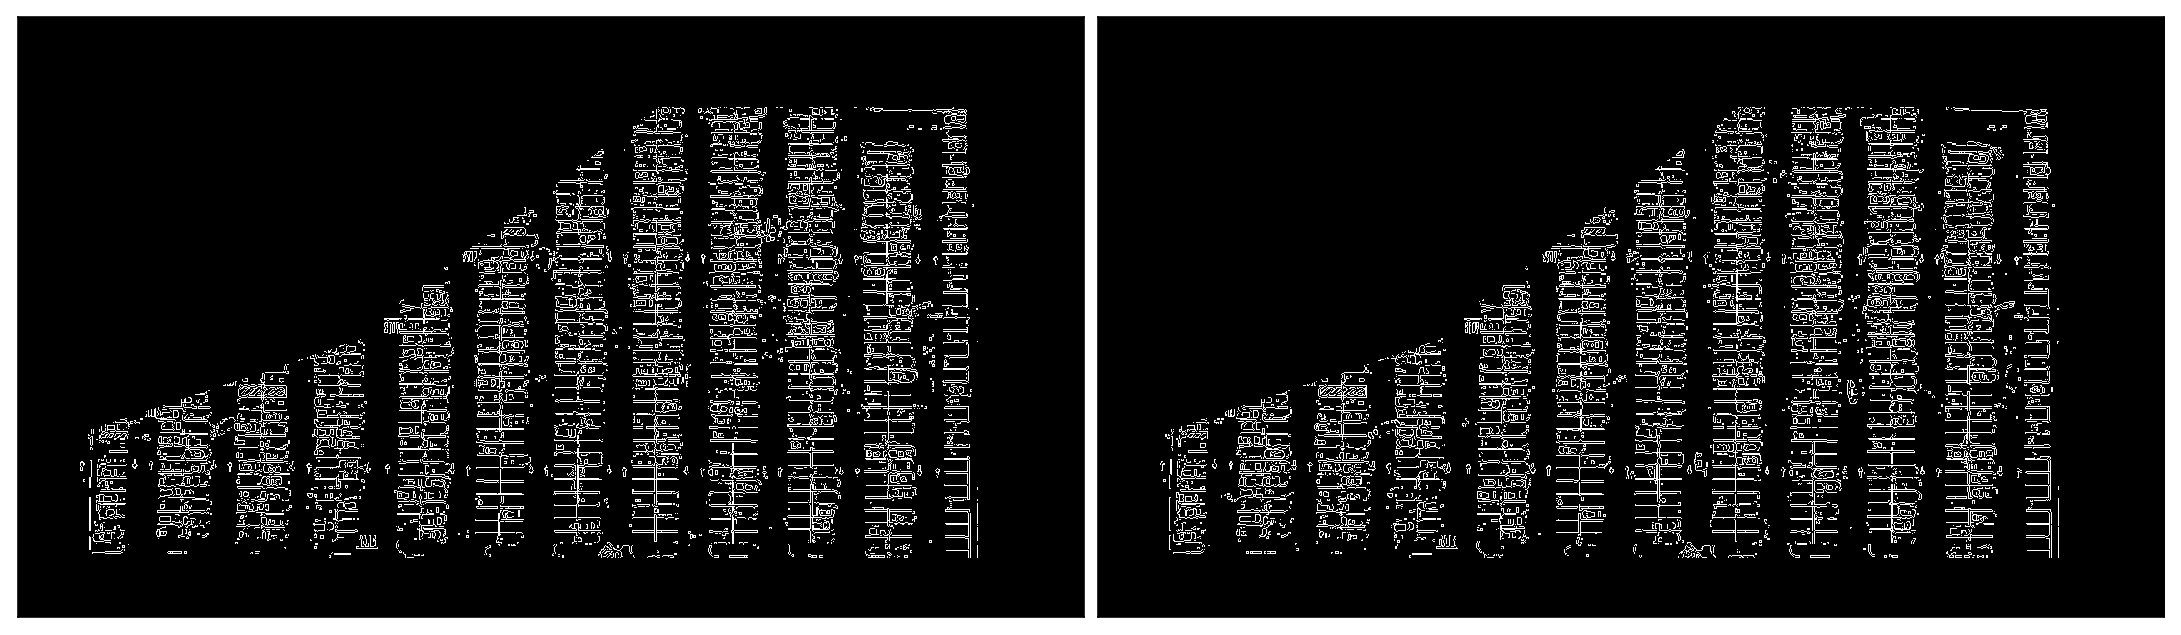

In [8]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    pt_1  = [cols*0.05, rows*0.90]
    pt_2 = [cols*0.05, rows*0.70]
    pt_3 = [cols*0.30, rows*0.55]
    pt_4 = [cols*0.6, rows*0.15]
    pt_5 = [cols*0.90, rows*0.15] 
    pt_6 = [cols*0.90, rows*0.90]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4, pt_5, pt_6]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

### **Hough line transform**

In [0]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4)


list_of_lines = list(map(hough_lines, roi_images))


In [11]:

def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=1 and abs(x2-x1) >=25 and abs(x2-x1) <= 55:
                cleaned.append((x1,y1,x2,y2))
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    print(" No lines detected: ", len(cleaned))
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

Output hidden; open in https://colab.research.google.com to view.

### **Identify rectangular blocks of parking**

In [12]:
def identify_blocks(image, lines, make_copy=True):
    if make_copy:
        new_image = np.copy(image)
    #Step 1: Create a clean list of lines
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=1 and abs(x2-x1) >=25 and abs(x2-x1) <= 55:
                cleaned.append((x1,y1,x2,y2))
    
    #Step 2: Sort cleaned by x1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(0, 1))
    
    #Step 3: Find clusters of x1 close together - clust_dist apart
    clusters = {}
    dIndex = 0
    clus_dist = 10

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][0] - list1[i][0])
    #         print(distance)
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])

        else:
            dIndex += 1
    
    #Step 4: Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > 5:
            cleaned = sorted(cleaned, key=lambda tup: tup[1])
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
    #         print(avg_y1, avg_y2)
            avg_x1 = 0
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 += tup[0]
                avg_x2 += tup[2]
            avg_x1 = avg_x1/len(cleaned)
            avg_x2 = avg_x2/len(cleaned)
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
    
    print("Num Parking Lanes: ", len(rects))
    #Step 5: Draw the rectangles on the image
    buff = 7
    for key in rects:
        tup_topLeft = (int(rects[key][0] - buff), int(rects[key][1]))
        tup_botRight = (int(rects[key][2] + buff), int(rects[key][3]))
#         print(tup_topLeft, tup_botRight)
        cv2.rectangle(new_image, tup_topLeft,tup_botRight,(0,255,0),3)
    return new_image, rects

# images showing the region of interest only
rect_images = []
rect_coords = []
for image, lines in zip(test_images, list_of_lines):
    new_image, rects = identify_blocks(image, lines)
    rect_images.append(new_image)
    rect_coords.append(rects)
    
show_images(rect_images)

Output hidden; open in https://colab.research.google.com to view.

### **Identify each spot and count num of parking spaces Next step-**

Based on width of each parking line segment into individual spots
draw a visualization of all parking spaces

In [13]:
def draw_parking(image, rects, make_copy = True, color=[255, 0, 0], thickness=2, save = True):
    if make_copy:
        new_image = np.copy(image)
    gap = 15.5
    spot_dict = {} # maps each parking ID to its coords
    tot_spots = 0
    adj_y1 = {0: 20, 1:-10, 2:0, 3:-11, 4:28, 5:5, 6:-15, 7:-15, 8:-10, 9:-30, 10:9, 11:-32}
    adj_y2 = {0: 30, 1: 50, 2:15, 3:10, 4:-15, 5:15, 6:15, 7:-20, 8:15, 9:15, 10:0, 11:30}
    
    adj_x1 = {0: -8, 1:-15, 2:-15, 3:-15, 4:-15, 5:-15, 6:-15, 7:-15, 8:-10, 9:-10, 10:-10, 11:0}
    adj_x2 = {0: 0, 1: 15, 2:15, 3:15, 4:15, 5:15, 6:15, 7:15, 8:10, 9:10, 10:10, 11:0}
    for key in rects:
        # Horizontal lines
        tup = rects[key]
        x1 = int(tup[0]+ adj_x1[key])
        x2 = int(tup[2]+ adj_x2[key])
        y1 = int(tup[1] + adj_y1[key])
        y2 = int(tup[3] + adj_y2[key])
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
        num_splits = int(abs(y2-y1)//gap)
        for i in range(0, num_splits+1):
            y = int(y1 + i*gap)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
        if key > 0 and key < len(rects) -1 :        
            #draw vertical lines
            x = int((x1 + x2)/2)
            cv2.line(new_image, (x, y1), (x, y2), color, thickness)
        # Add up spots in this lane
        if key == 0 or key == (len(rects) -1):
            tot_spots += num_splits +1
        else:
            tot_spots += 2*(num_splits +1)
            
        # Dictionary of spot positions
        if key == 0 or key == (len(rects) -1):
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                spot_dict[(x1, y, x2, y+gap)] = cur_len +1        
        else:
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                x = int((x1 + x2)/2)
                spot_dict[(x1, y, x, y+gap)] = cur_len +1
                spot_dict[(x, y, x2, y+gap)] = cur_len +2   
    
    print("total parking spaces: ", tot_spots, cur_len)
    if save:
        filename = 'with_parking.jpg'
        cv2.imwrite(filename, new_image)
    return new_image, spot_dict

delineated = []
spot_pos = []
for image, rects in zip(test_images, rect_coords):
    new_image, spot_dict = draw_parking(image, rects)
    delineated.append(new_image)
    spot_pos.append(spot_dict)
    
show_images(delineated)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
final_spot_dict = spot_pos[1]
print(len(final_spot_dict))

551


In [15]:
def assign_spots_map(image, spot_dict=final_spot_dict, make_copy = True, color=[255, 0, 0], thickness=2):
    if make_copy:
        new_image = np.copy(image)
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        cv2.rectangle(new_image, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
    return new_image

marked_spot_images = list(map(assign_spots_map, test_images))
show_images(marked_spot_images)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
### Save spot dictionary as pickle file
import pickle

with open('/content/gdrive/My Drive/app/parking_spots_detector/spot_dict.pickle', 'wb') as handle:
    pickle.dump(final_spot_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### **Save image for CNN model**

In [0]:
def save_images_for_cnn(image, spot_dict = final_spot_dict, folder_name ='/content/gdrive/My Drive/app/parking_spots_detector/for_cnn'):
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        #crop this image
#         print(image.shape)
        spot_img = image[y1:y2, x1:x2]
        spot_img = cv2.resize(spot_img, (0,0), fx=2.0, fy=2.0) 
        spot_id = spot_dict[spot]
        
        filename = 'spot' + str(spot_id) +'.jpg'
        print(spot_img.shape, filename, (x1,x2,y1,y2))
        
        cv2.imwrite(os.path.join(folder_name, filename), spot_img)
        
save_images_for_cnn(test_images[0])

### **Use trained CNN model to make predictions**

In [18]:
## Imports for making predictions
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
cwd = os.getcwd()
top_model_weights_path = '/content/gdrive/My Drive/app/parking_spots_detector/car1.h5'

class_dictionary = {}
class_dictionary[0] = 'empty'
class_dictionary[1] = 'occupied'

In [20]:
from PIL import Image
model = load_model(top_model_weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
def make_prediction(image):
    #Rescale image
    img = image/255.

    #Convert to a 4D tensor
    image = np.expand_dims(img, axis=0)
    #print(image.shape)

    # make predictions on the preloaded model
    class_predicted = model.predict(image)
    inID = np.argmax(class_predicted[0])
    label = class_dictionary[inID]
    return label

In [23]:
def predict_on_image(image, spot_dict = final_spot_dict, make_copy=True, color = [0, 255, 0], alpha=0.5):
    if make_copy:
        new_image = np.copy(image)
        overlay = np.copy(image)
    cnt_empty = 0
    all_spots = 0
    for spot in spot_dict.keys():
        all_spots += 1
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        #crop this image
        spot_img = image[y1:y2, x1:x2]
        spot_img = cv2.resize(spot_img, (48, 48)) 
        
        label = make_prediction(spot_img)
#         print(label)
        if label == 'empty':
            cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
            cnt_empty += 1
            
    cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)
            
    cv2.putText(new_image, "Available: %d spots" %cnt_empty, (30, 95),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    
    cv2.putText(new_image, "Total: %d spots" %all_spots, (30, 125),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    #save = False
    save = True
    
    if save:
        filename = '/content/gdrive/My Drive/app/parking_spots_detector/with_marking.jpg'
        cv2.imwrite(filename, new_image)
    
    return new_image


predicted_images = list(map(predict_on_image, test_images))
show_images(predicted_images)

Output hidden; open in https://colab.research.google.com to view.

### **Run code on video**

In [32]:
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2_imshow

video_name = '/content/gdrive/My Drive/app/parking_spots_detector/parking_video.mp4'
cap = cv2.VideoCapture(video_name)
ret = True
count = 0

while ret:
        ret, image = cap.read()
        count += 1
        if count == 5:
            count = 0
            
            new_image = np.copy(image)
            overlay = np.copy(image)
            cnt_empty = 0
            all_spots = 0
            color = [0, 255, 0] 
            alpha=0.5
            for spot in final_spot_dict.keys():
                all_spots += 1
                (x1, y1, x2, y2) = spot
                (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
                #crop this image
                spot_img = image[y1:y2, x1:x2]
                spot_img = cv2.resize(spot_img, (48, 48)) 

                label = make_prediction(spot_img)
        #         print(label)
                if label == 'empty':
                    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
                    cnt_empty += 1

            cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)

            cv2.putText(new_image, "Available: %d spots" %cnt_empty, (30, 95),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)

            cv2.putText(new_image, "Total: %d spots" %all_spots, (30, 125),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)
            cv2_imshow(new_image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        #out.write(image)

cv2.destroyAllWindows()
cap.release()

Output hidden; open in https://colab.research.google.com to view.